# This dataset is focus on hyperparameter tuning and at the end there is an example with multivariate forecasting
- In fuzzy time series, what are the different parameter that we can tune? 
- How to assess the performance per combination of parameter? 
- What is the effect of the number of partition on the performance of the model? 
- At what point are we overfitting by increasing the # of partitions? 
- What is the effect of order on the performance and complexity of the model? 
- How can we deal with the effect of 0 in the series.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/philippebeliveau/Desktop/Bureau/Notebook_Jupyter_R/datah-m1-challange/sales.csv")

In [3]:
df.head()

,DATE,S100,I100,C100,C101,QTT
0,2017-01-08,0,0,12,76,2
1,2017-01-08,0,0,12,149,3
2,2017-01-08,0,0,12,256,3
3,2017-01-08,0,0,12,354,3
4,2017-01-08,0,0,13,149,2


In [4]:
df.shape[0]

2749369

Starts in 2017 and end in 2021

<function matplotlib.pyplot.show(close=None, block=None)>

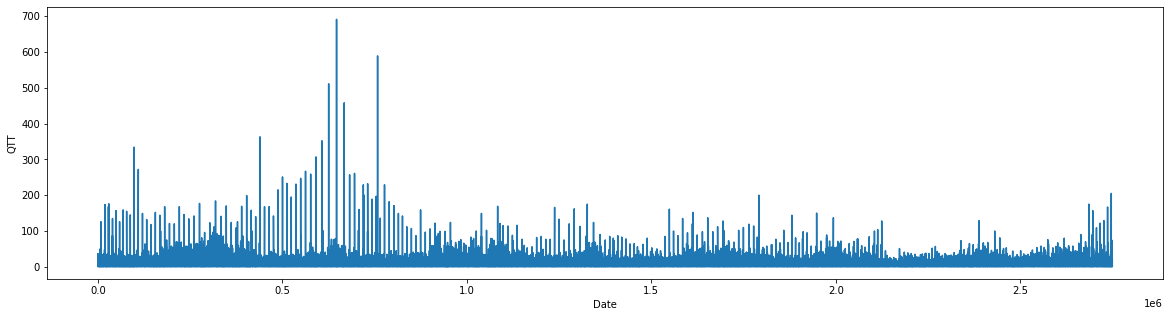

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df["QTT"])

plt.xlabel("Date")
plt.ylabel("QTT")
plt.show

## Number of zeros

In [6]:
df.eq(0).sum()

DATE        0
S100    99850
I100     8841
C100     6601
C101       89
QTT         0
dtype: int64

## Transformation
We can use pyFTS own transformations tool. Although, I am not sure how are we going to integrate our own transformation in the partionning function.

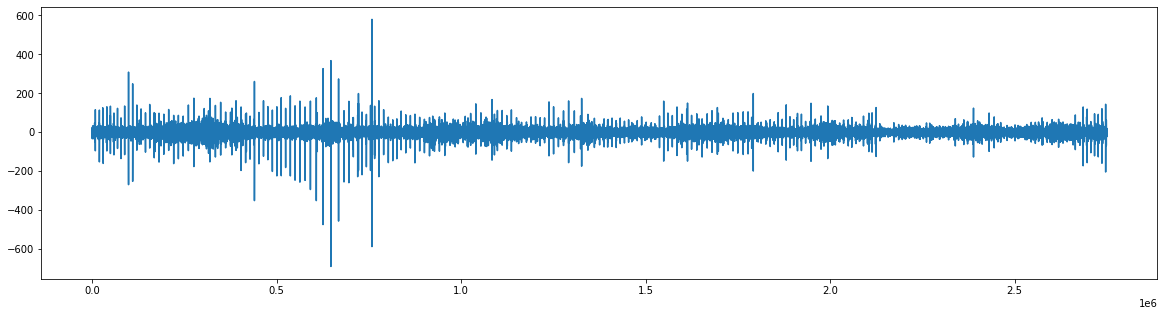

In [6]:
from pyFTS.common import Transformations

diff = Transformations.Differential(1)
fig = plt.subplots(figsize=(20,5))
plt.plot(diff.apply(df["QTT"].values), label="QTT")
pass

# Train test split
Only the training data seems to be partionned. 

In [5]:
train = df.iloc[:2000000]
test = df.iloc[2000001:2749369]

uni_train = train["QTT"].values
multi_train = train.values

uni_test = test['QTT'].values
multi_test = test.values

# Training phase

## Step 1 - Universe of Discourse partitioning: 
partitioning is the most significant part of training phase. It is applied
to split the Universe of Discourse U into fuzzy sets by making linguistic values A˜ through various types of
available techniques in the literature.

In [7]:
from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership as mf
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.data import Enrollments

## Hyperparameter in the training phase
#### Data partitioning
Creation of A˜ (partitions) strongly depends on three hyperparameters: the number of partitions, the partitioning
techniques and membership function µ.

#### Partioning technique
The partitioning methods are commonly divided into two groups according to the length or size of intervals: fixed (equal)
intervals and unequal interval techniques as illustrated in Figure 2.
In an equal-sized partitioning technique the length of generated fuzzy sets are equal. Due to its main advantages, which are
simplicity and not being time consuming, it has been adopted by numerous scientists [13–27]. Grid partitioning proposed in [8]
is known as the simplest partitioning scheme. Considering k as the number of intervals, then in Grid partitioning method, k fuzzy
sets with the same size will be created by splitting U into k overlapping fuzzy sets. Some works in the literature used simple
heuristic partitioning methods, including [28–32].

#### The Number of Partitions k
Another parameter that has a strong effect on the accuracy of the model is the number of fuzzy sets. Choosing a large value for k increases the complexity of the model because too many
fuzzy sets and rules are generated, perhaps more than the required number. This factor has effect on the readability and explainability of the model [83].

#### The Membership Function
The membership function specifies the degree in [0, 1] to which a crisp value belongs to a fuzzy set. Although the influence on
the accuracy is less important than other parameters, it is recommended to test different fuzzy sets in the model. Trapezoidal,
Triangular and Gaussian are the most common ones. 

#### Parameters 
data: the time series training data;
* npart: the minimum number of partitions/fuzzy sets;
* mf: the membership function that will be used, which by default is triangular (trimf). The various membership
functions can be found in pyFTS.common.Membership;
* transformation: if any transformation is used in the series, it must be informed.

/opt/anaconda3/envs/Fuzzy_TS/lib/python3.6/site-packages/pyFTS/partitioners/partitioner.py:238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


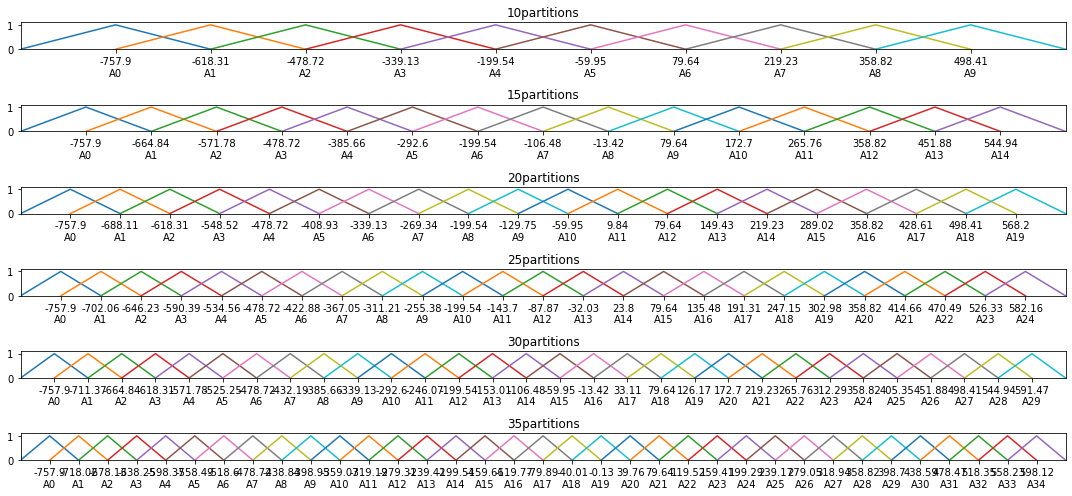

In [9]:
fig, ax = plt.subplots(nrows=6, ncols=1,figsize=[15,7])

for ct, npart in enumerate(np.arange(10,40, 5)):
  part = Grid.GridPartitioner(data=uni_train, npart=npart, mf=[mf.gaussmf], transformation=diff)
  part.name = str(npart) + "partitions"
  
  part.plot(ax[ct], rounding=2)
 
plt.tight_layout()

### Hyper-1: Finding the best number of partitions

TypeError: predict() missing 1 required positional argument: 'data'

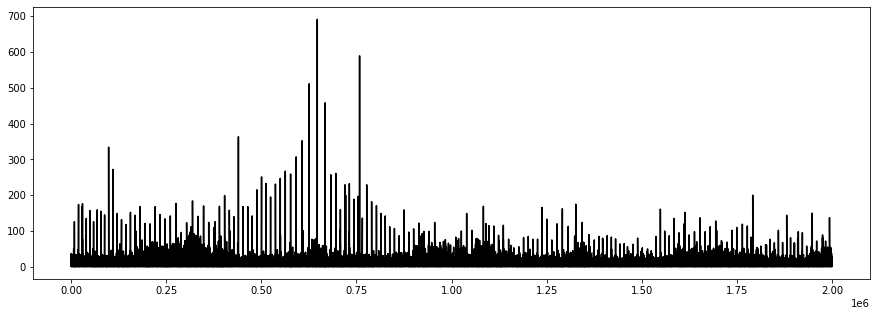

In [10]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_train, label='Original',color='black')

for npart in np.arange(5,35,5):
  part = Grid.GridPartitioner(data=uni_train, npart=npart)
  model = hofts.HighOrderFTS(order=1, partitioner=part)
  model.fit(uni_train)
  forecasts = model.predict(y=uni_train)
    
  ax.plot(forecasts[:-1], label=str(npart) + " partitions")
  
  rmse, mape, u = Measures.get_point_statistics(uni_train, model)
  
  rows.append([npart, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

## Hyper-2 : Order

In [ ]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_train, label='Original',color='black')

for order in np.arange(1,4):
  part = Grid.GridPartitioner(data=uni_train, npart=10)
  model = hofts.HighOrderFTS(order=order, partitioner=part)
  model.fit(uni_train)
  forecasts = model.predict(uni_train)
  if order > 1:
    for k in np.arange(order):
      forecasts.insert(0,None)

  ax.plot(forecasts[:-1], label=str(order) + " order")
  
  rmse, mape, u = Measures.get_point_statistics(uni_train, model)
  
  rows.append([order, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Order','RMSE','MAPE','U'])
     

## Hyper-3 : Method

In [ ]:
from pyFTS.models import hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_train, label='Original',color='black')

part = Grid.GridPartitioner(data=uni_train, npart=10)

for method in [hofts.HighOrderFTS, hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]:
  model = method(order=1, partitioner=part)
  model.fit(uni_train)
  forecasts = model.predict(uni_train)

    
  ax.plot(forecasts[:-1], label=model.shortname)
  
  rmse, mape, u = Measures.get_point_statistics(uni_train, model)
  
  rows.append([model.shortname, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Model','RMSE','MAPE','U'])

In [12]:
parts = Grid.GridPartitioner(data=uni_train, npart=15, transformation=diff)

## Step 2 - Fuzzification: 
in this step the numeric data Y is converted into linguistic variables A˜ via given partitioning
method with regards to their memberships degrees to the fuzzy sets. The obtained linguistic or fuzzified version
of y(t) ∈ Y , represents the fuzzy time series F in which f(t) ∈ F are fuzzy values.

Fuzzification is a process of transforming crisp values to the linguistic terms or fuzzy quantities. In Fuzzy Time Series model,
each interval contains significant information occurred in the past. So, for preventing the important information to be lost, the
fuzzy sets need to be managed in an efficient way. 

Initial studies in [8, 13, 30] proposed the maximum membership degree as the main fuzzification method, that is,
just the fuzzy set with the greatest membership value is considered. It is computationally simple but the likelihood of losing
information will be high by ignoring various neighbouring membership degrees as well as raising the risk of under-fitting.

For solving this issue, the holistic fuzzification approach is proposed as an alternative. In this process instead of considering
only the maximum membership degree, all members are taken into account. 

### Question 
- What is the effect of the number of partitions on the fuzzification -process?
- I don't see how this fuzzyfication procedure consider the transformation on the series. I believe I have to put those line of code within a function altogether

In [18]:
from pyFTS.common import FuzzySet as fz
F = fz.fuzzyfy_series(uni_train, parts.sets)
print(F)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



I feel like Fuzzy sets are not good when dealing with zeros.

## Step 3 - Knowledge or Temporal Pattern Extraction:
This step focuses mainly on extracting knowledge from F due
to the past observations or lags. In other words, this stage analyzes the sequential terms in F, grouping the
patterns in rules (Ai) → (Aj ),(Ak), . . . and can be said that if f(t) is (Ai) then f(t + 1) is (Aj ),(Ak), . . ..
For example, in Figure 1, A4 and A3 generate the fuzzy logical rule (FLR) A4 → A3 which is then grouped
into the GFLR A4 → A4, A5, A3.

### "Hyperparemeter" or other techniques to do pattern extraction
- Matrix and Rule-based Models
- Feed forward neural network can be used to determine fuzzy relations. 
- Hybrid Method with Smart Techniques
- Hybrid Method with Statistical Models
- Weighted Rule Models: 
The occurrence of temporal patterns in the historical data when building the FLRG is one of the issues which has been ignored
by researchers [13, 28, 93, 94, 99], which means that the importance of recurrent and unique patterns of data in forecasting is the
same. Furthermore the weights of recent and older patterns are the same in the basic FTS methods. Thus Yu [30] proposed the
Weighted Fuzzy Time Series (WFTS), which adds weights to FLRG considering rule’s recurrence and their chronological order.
In this way different weights are given to the individual fuzzy relations.

### Generate the rules

In [125]:
from pyFTS.common import FLR
rules = FLR.generate_non_recurrent_flrs(F)
print([str(k) for k in rules[0:10]])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A0 -> A2', 'A2 -> A0', 'A2 -> A2', 'A1 -> A1', 'A2 -> A3', 'A3 -> A0', 'A1 -> A3']


## Question 
- The rules generated seems to not use enough partitions. 
- How to allow the model to use more partition? 

### Make the grouping of the rules
Dont forget to transform the data into .values

### Debuzzification process for chen
In Chen’s model [13], the defuzzification process is based on the following regulations:
1. If the consequence or RHS of the rule is empty, then the yˆ(t + 1) is the midpoint of the fuzzy set f(t), corresponding to a
na¨ıve forecast.
2. If the RHS in FLR consists of only one fuzzy set, yˆ(t + 1) is the midpoint of the corresponding fuzzy set.
3. Otherwise, the value of yˆ(t + 1) is the mean value of midpoints of those fuzzy sets in the RHS.

In [ ]:
from pyFTS.models import chen
model = chen.ConventionalFTS(partitioner=parts)
model.fit(uni_train, order=1)
print(model)

chen.conventionalFTS : https://www.researchgate.net/publication/220231471_Forecasting_Enrollments_Based_on_High-Order_Fuzzy_Time_Series

# Forecasting procedure

## Step 1 - Fuzzification: 
the fuzzification step is the same for both forecasting process and training procedure. It means
that it translates the numeric sample y(t) ∈ Y into a fuzzy value f(t), where f(t) ∈ A˜.

In [ ]:
from pyFTS.common import FuzzySet as fz
f = fz.get_maximum_membership_fuzzyset(uni_train.values.any(), parts.sets)
print(f)

## Step 2 - Defuzzification: 

The Defuzzification is different per model! 

The initial method presented by Song and Chissom [8, 9] follows the principles bellow:
1. If there is only one membership with the greatest value in the output vector, then the forecasted value yˆ(t + 1) is the
midpoint of the fuzzy set with this maximum membership.
2. If there is more than one consecutive maximum membership, yˆ(t + 1) will be calculated by averaging the midpoints of the
corresponding fuzzy sets.
3. Otherwise, yˆ(t + 1) will be the mean value of midpoints of each fuzzy set. In other words we have yˆ(t + 1) = P
i µi · cj for j ∈ f(t). µi is the membership degree and cj is the midpoint of each fuzzy set.

Defuzzification Process
The last step of FTS forecasting process is defuzzification which converts fuzzy sets in the RHS of the rules to a numerical
value. In this process the obtained fuzzified value f(t+1) is mapped into the single crisp number yˆ(t+1). Various defuzzification
methods exist in the literature. The initial method presented by Song and Chissom [8, 9] follows the principles bellow:

Now it is necessary to convert f(t + 1) to a numerical value. The predict method uses the already
trained model to make predictions. There are three possible forecast types, indicated by the ’type’ parameter: ’point’
(default), ’interval’ and ’distribution’. Read about the model used, as not all of them work with all forecast types.
Finally, the ’steps ahead’ parameter indicates the forecast horizon, or how many steps ahead you want to forecast.

In [ ]:
len(uni_train)

In [ ]:
forecasts = model.predict(uni_test.values, type='point', steps_ahead=1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])
ax.plot(forecasts)
ax.set_title("experiment")
    
plt.tight_layout()

In [ ]:
from pyFTS.benchmarks import Measures

rows = []
row.extend(Measures.get_point_statistics(uni_test.values, model))

rows.append(row)

    
pd.DataFrame(rows,columns=["RMSE","SMAPE","Theil's U"])
    

# 2nd experience with multivariate series